In [4]:
%pylab inline
import pandas as pd
from dateparser import parse


Populating the interactive namespace from numpy and matplotlib


In [5]:
#!pip install dateparser

In [7]:
ex = pd.ExcelFile('WDImetadata.xlsx')
explainer = ex.parse('2010-2019 MetaData').set_index('Code').fillna('')
def explain(c):
    global explainer
    return explainer.loc[c]['Long definition']

In [8]:
'''
Data Cleaning
'''

df = pd.read_excel('WDIdata3decades.xlsx')

'''
Find codes that exist in all three decades:
'''
decades = ['1990-1999 MetaData',
           '2000-2010 MetaData',
           '2010-2019 MetaData']
decade_codes = [set(ex.parse(d)['Code']) for d in decades]

decade_count = df.groupby('Custom_Time_Code').apply(lambda x: pd.notnull(x).sum(0))

not_null_thresh = 20
preserved = ((decade_count > not_null_thresh).sum() == decade_count.shape[0])
data = df.T[preserved].T

data.Custom_Time_Code = data.Custom_Time_Code.apply(lambda x: parse(x[:4]))

In [9]:
def find_codes(input_string):
    terms = input_string.split()
    for code in explainer.T.columns:
        if False not in [s.upper() in str(explainer['Long definition'][code]).upper() or \
                          s.upper() in str(explainer['Indicator Name'][code]).upper() or \
                          s.upper() in str(explainer['Unit of measure'][code]).upper() for s in terms]:
            if code in data.columns:
                print(code)
                print(explainer.loc[code]['Indicator Name'])
                print(explain(code))
                print()

In [10]:
explain('NY.ADJ.NNTY.KD')

'Adjusted net national income is GNI minus consumption of fixed capital and natural resources depletion.'

In [11]:
find_codes('economy')

BN.KLT.DINV.CD
Foreign direct investment, net (BoP, current US$)
Foreign direct investment are the net inflows of investment to acquire a lasting management interest (10 percent or more of voting stock) in an enterprise operating in an economy other than that of the investor. It is the sum of equity capital, reinvestment of earnings, other long-term capital, and short-term capital as shown in the balance of payments. This series shows total net FDI. In BPM6, financial account balances are calculated as the change in assets minus the change in liabilities. Net FDI outflows are assets and net FDI inflows are liabilities. Data are in current U.S. dollars.

BX.KLT.DINV.WD.GD.ZS
Foreign direct investment, net inflows (% of GDP)
Foreign direct investment are the net inflows of investment to acquire a lasting management interest (10 percent or more of voting stock) in an enterprise operating in an economy other than that of the investor. It is the sum of equity capital, reinvestment of earnin

In [12]:
data[data['Country Code']=='USA']

,Custom_Time_Code,Country Code,EG.ELC.ACCS.ZS,EG.ELC.ACCS.RU.ZS,EG.ELC.ACCS.UR.ZS,SE.PRM.TENR,SE.PRM.TENR.FE,SE.PRM.TENR.MA,NY.ADJ.NNTY.KD.ZG,NY.ADJ.NNTY.KD,...,SL.EMP.VULN.FE.ZS,SL.EMP.VULN.MA.ZS,SL.EMP.VULN.ZS,SL.EMP.WORK.FE.ZS,SL.EMP.WORK.MA.ZS,SL.EMP.WORK.ZS,SP.DYN.WFRT,SP.M15.2024.FE.ZS,SP.M18.2024.FE.ZS,SH.DYN.AIDS.FE.ZS
72,1990-04-14,USA,100,100,100,97.3845,97.5423,97.234,3.52104,8.70082e+12,...,4.34478,5.60278,5.03533,93.3649,90.027,91.5322,NaN,NaN,NaN,NaN
151,2000-04-14,USA,100,100,100,98.5781,98.7026,98.1999,1.59212,1.18916e+13,...,3.8415,4.8704,4.398,94.0405,91.4237,92.6249,NaN,NaN,NaN,NaN
230,2010-04-14,USA,100,100,100,97.5206,97.5436,97.4986,2.66491,1.39244e+13,...,3.4324,4.2991,3.8994,94.6312,92.5103,93.4884,NaN,NaN,NaN,NaN


In [13]:
data['VC.IHR.PSRC.P5']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
232     1.5
233     NaN
234     5.9
235     5.7
236    5.85
Name: VC.IHR.PSRC.P5, Length: 237, dtype: object

In [14]:
data['f_to_m_enrollment'] = (data['SE.PRM.TENR.FE']/data['SE.PRM.TENR.MA'])

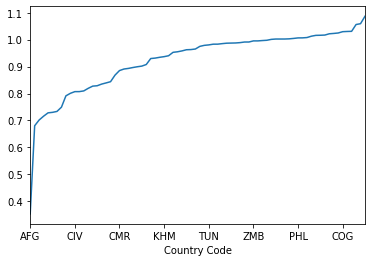

In [15]:
def agg_w_nan(s, func):
    s = s.dropna()
    if len(s)>=1:
        return s.agg(func)
    else:
        return np.nan

data.groupby('Country Code').f_to_m_enrollment.apply(lambda x: agg_w_nan(x, 'mean')).dropna().sort_values().plot()

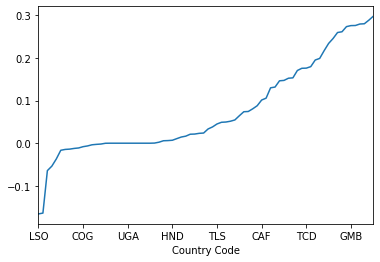

In [16]:
def s_chg(s):
    s = s.values
    return s[-1]-s[0]

data.groupby('Country Code').f_to_m_enrollment.apply(lambda x: agg_w_nan(x, s_chg)).dropna().sort_values().plot()


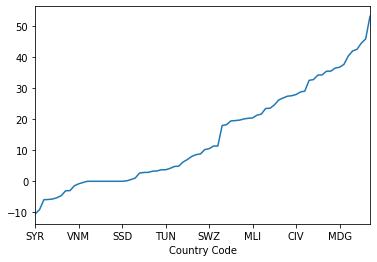

In [17]:
data.groupby('Country Code')['SE.PRM.TENR'].apply(lambda x: agg_w_nan(x, s_chg)).dropna().sort_values().plot()



In [18]:
gini_chg = data.groupby('Country Code')['SI.POV.GINI'].apply(lambda x: agg_w_nan(x, s_chg)).dropna()
gdp_chg = data.groupby('Country Code')['NY.GDP.PCAP.CD'].apply(lambda x: agg_w_nan(x, s_chg)).dropna()



In [19]:

both = pd.concat([gini_chg, gdp_chg], axis=1).dropna()


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


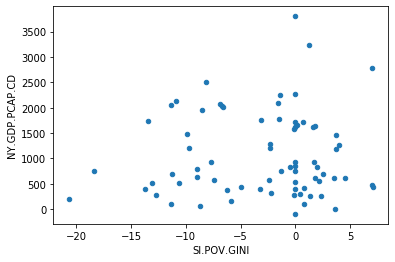

In [21]:
both['country'] = both.index
both[both.country != 'USA'].plot.scatter(x = 'SI.POV.GINI', y='NY.GDP.PCAP.CD')